# Example of Our Pre-processing Pipeline

## Single CSV from Lunar Mission Data


In [1]:
import numpy as np
import obspy
import emd
import pandas as pd
from tqdm.notebook import tqdm
import os
import scipy.signal as sg
from obspy.signal.trigger import recursive_sta_lta, classic_sta_lta
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib import pyplot as plt

## Lunar csv = xa.s15.00.mhz.1973-04-04HR00_evid00098

### 1. Lunar Data (Reading the MiniSEED file)
- **Objective**: Load seismic activity data from lunar recordings stored in MiniSEED format files.
- **Process**: 
  - A CSV file (`catalogy`) is read to obtain information about seismic events (such as file name and event arrival time).
  - The code checks if the seismic data file exists and loads it using `obspy`, a specialized library for handling seismic data.
  - The seismic signal is converted to micrometers (multiplied by 1e6) for easier manipulation, and both the signal time and the sampling rate (fs) are extracted.

Text(0.5, 0, 'Time (s)')

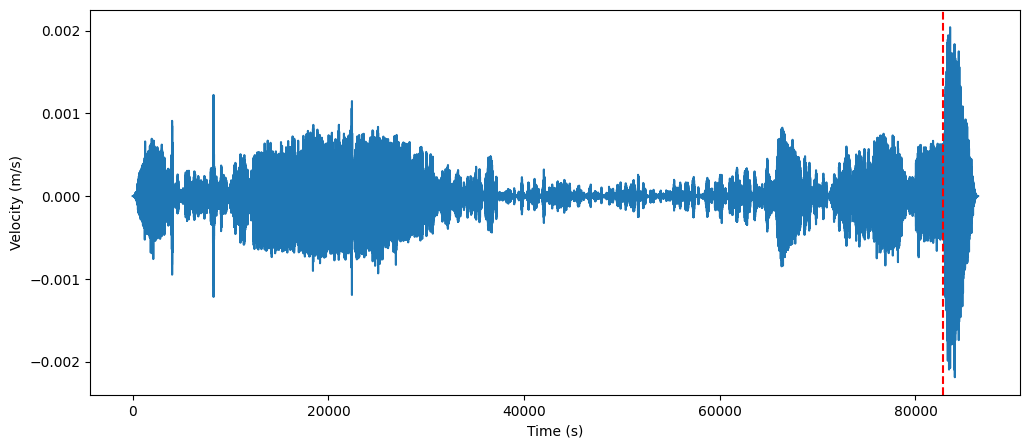

In [2]:
# Carregando o catálogo e configurando o diretório de dados
catalogy = pd.read_csv(r'data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv')
data_folder = r'data\lunar\training\data\S12_GradeA'

# Selecionando o índice do catálogo
idx = 42

# Carregando o nome do arquivo e o tempo de chegada
fileName = catalogy.at[idx, 'filename'] + '.mseed'
arrival_time = catalogy.at[idx, 'time_rel(sec)']

# Verificando se o arquivo existe
if not os.path.exists(os.path.join(data_folder, fileName)):
    raise FileNotFoundError(f"Arquivo {fileName} não encontrado.")

# Carregando o arquivo MiniSEED
stream = obspy.read(os.path.join(data_folder, fileName))
data = stream[0].data * 1e6
time = stream[0].times()
fs = stream[0].stats.sampling_rate

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(time, data)
ax.axvline(arrival_time, color='r', linestyle='--')
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')


### 3. Band-Pass Filter
- **Objective**: Remove unwanted frequency components from the signal while preserving the spectrum of interest.
- **Process**: 
  - A band-pass filter is applied to the signal, allowing only frequencies between 0.4 Hz and 1.2 Hz to pass, removing frequencies outside this range.
  - This is done using a 6th-order Butterworth filter (a common digital filter in signal processing).
  - This step is important to isolate the relevant frequencies for seismic analysis, eliminating noise.


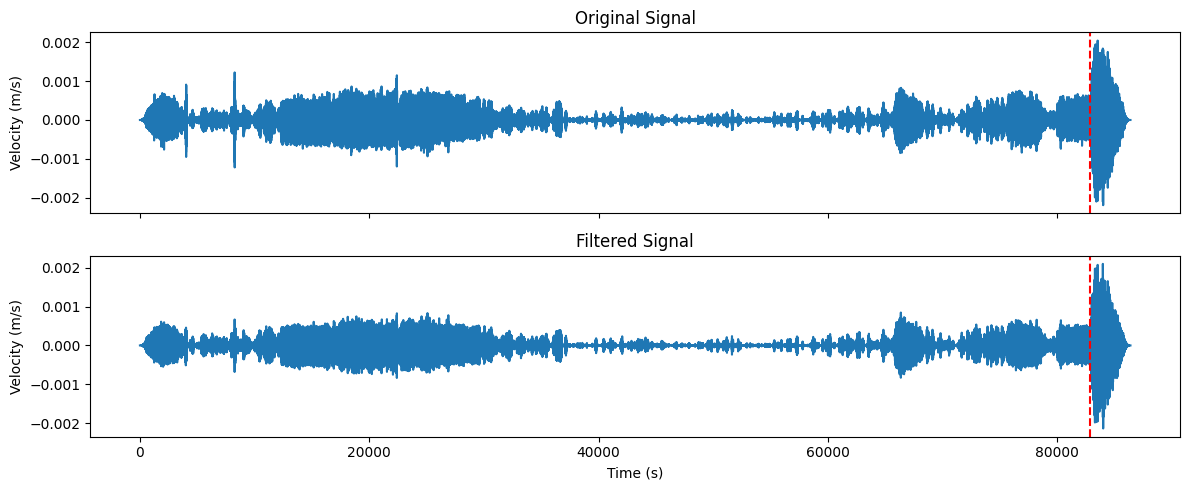

In [3]:
def butter_bandpass_filter(data:np.array, lowcut:float, highcut:float, fs:float, order:int):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sg.butter(order, [low, high], btype='band', analog=False)
    y = sg.filtfilt(b, a, data)
    return y

data_filtered = butter_bandpass_filter(data, 0.4, 1.2, fs, 6)

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].plot(time, data)
ax[0].axvline(arrival_time, color='r', linestyle='--')
ax[0].set_ylabel('Velocity (m/s)')
ax[0].set_title('Original Signal')

ax[1].plot(time, data_filtered)
ax[1].axvline(arrival_time, color='r', linestyle='--')
ax[1].set_ylabel('Velocity (m/s)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Filtered Signal')
fig.tight_layout()

### 6. EMD (Empirical Mode Decomposition)
- **Objective**: Extract basic oscillatory components from the signal to facilitate analysis of its properties across different frequency scales.
- **Process**: 
  - EMD (Empirical Mode Decomposition) is a technique used to decompose complex signals into a set of functions called IMFs (Intrinsic Mode Functions).
  - Each IMF represents oscillations at a different frequency in the original signal.
  - This technique is useful for capturing different frequency patterns in the signal, which could be related to different seismic phenomena.


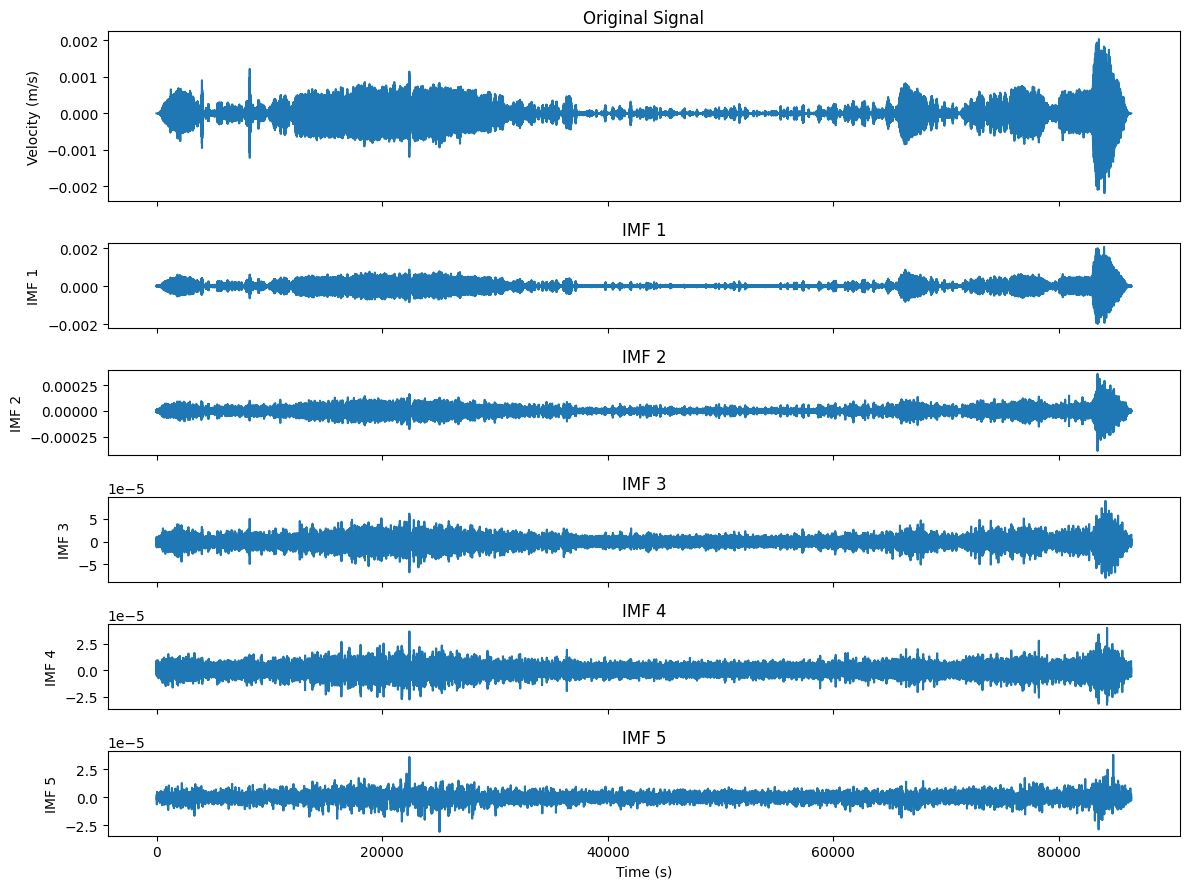

In [4]:
# Aplicando EMD para extrair IMFs
imfs = emd.sift.ensemble_sift(data_filtered, max_imfs=5)

widthRatio = [1] + [0.5] * imfs.shape[1]

fig, ax = plt.subplots(imfs.shape[1]+1, 1, figsize=(12, 9), sharex=True, gridspec_kw={'height_ratios': widthRatio})
ax[0].plot(time, data)
ax[0].set_ylabel('Velocity (m/s)')
ax[0].set_title('Original Signal')

for i in range(imfs.shape[1]):
    ax[i+1].plot(time, imfs[:, i])
    ax[i+1].set_ylabel(f'IMF {i+1}')
    ax[i+1].set_title(f'IMF {i+1}')

ax[-1].set_xlabel('Time (s)')
fig.tight_layout()

### 7. Energy (Window Energy Calculation)
- **Objective**: Quantify the energy of the extracted IMFs for each window, indicating how much information is contained in each component.
- **Process**: 
  - The energy of the IMFs in each window is calculated as the sum of the squares of the values within a window (indicating the strength of each component).
  - This calculation helps identify parts of the signal with higher seismic activity (high energy) or where the signal is weaker (low energy).
  - Energy is calculated for several "sub-windows" within each 10-minute window.


Text(0, 0.5, 'Window')

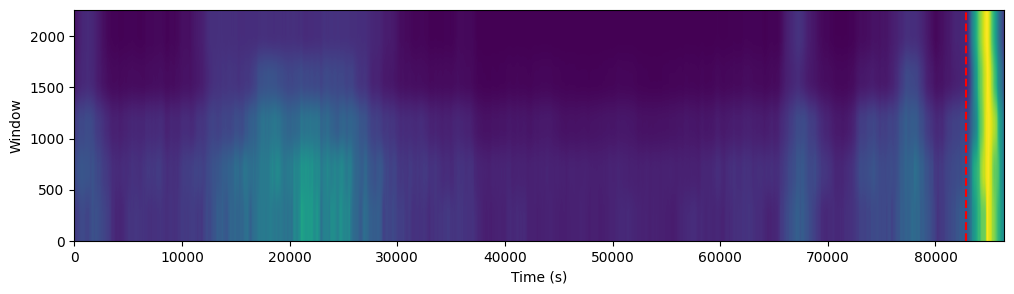

In [5]:
window_size_sec = 30 * 60 # 30 minutos
window_size = int(window_size_sec * fs)
window_step = window_size//48
energy = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::window_step,:,:]
energy = np.sum(energy, axis=-1)

maxEnergies = np.max(energy, axis=0)
energy = energy / maxEnergies

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(energy.T, aspect='auto', extent=[time[0], time[-1], 0, energy.shape[0]])
ax.axvline(arrival_time, color='r', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Window')

### 8. Labels
- **Objective**: Identify windows that contain seismic events and label them for machine learning model training.
- **Process**: 
  - The code checks whether the central time of a window is close to the arrival time of the seismic event recorded in the catalog.
  - If the window contains the event, it is assigned label 1, otherwise, it gets label 0.
  - This allows windows containing seismic events to be used as positive examples during model training for classification.


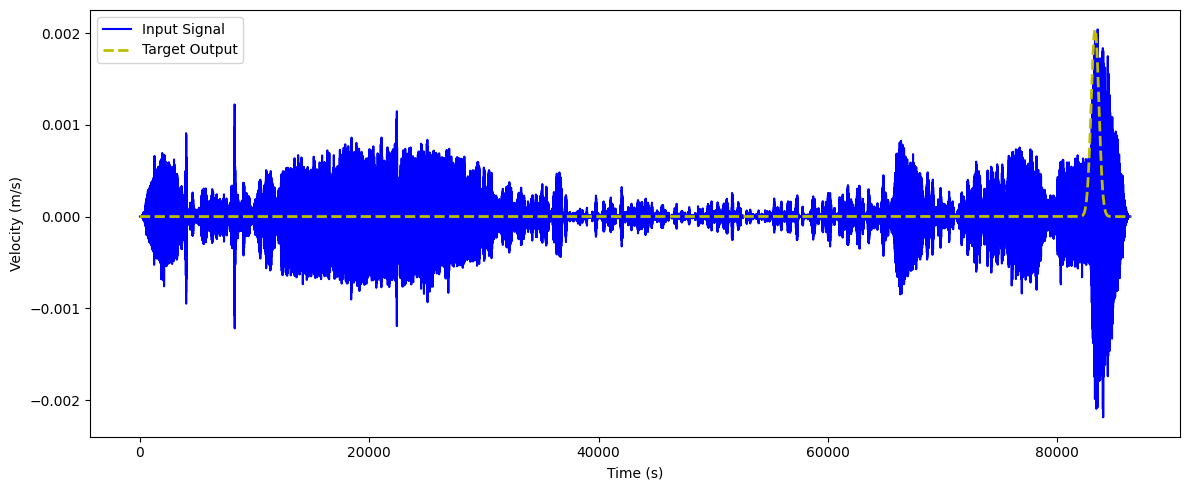

In [6]:
# Criando os rótulos baseados no tempo de chegada do evento
output = np.zeros((data.shape[0], ))
arrival_idx = np.where(time - window_size_sec/4 >= arrival_time)[0][0]
sigma = window_size/8*1.5
gaussian_window_size = int(window_size*1.5)
if gaussian_window_size % 2 == 1: gaussian_window_size += 1
gaussian_window = sg.windows.gaussian(gaussian_window_size, std=sigma)
left_idx = arrival_idx - (gaussian_window_size//2)
right_idx = arrival_idx + (gaussian_window_size//2)
if left_idx < 0:
    left_idx = 0
if right_idx > len(output):
    right_idx = len(output)
output[left_idx:right_idx] = gaussian_window[:right_idx-left_idx]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(time, data, 'b', label='Input Signal')
ax.plot(time, output*data.max(), 'y--', label='Target Output', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')
ax.legend()
fig.tight_layout()